# What is Sementic Segmentation?

![대체 텍스트](https://miro.medium.com/max/700/1*8Nwk_IdGpe235Nsfewpucg.png)

from Fei-Fei Li Stanford Course — Detection And Segmentation

# STEP 1: Dataset





https://www.kaggle.com/nikhilpandey360/lung-segmentation-from-chest-x-ray-dataset

![대체 텍스트](https://www.altoros.com/blog/wp-content/uploads/2018/12/segmentation-results-max-dice-score.png)


In [1]:
# 현재 위치의 파일 및 폴더 리스트 출력
!ls

sample_data


In [2]:
# 현재 위치 출력
!pwd

/content


In [3]:
# 데이터셋 다운로드 (깃허브)
!rm -rf *
!git clone https://github.com/kevinkwshin/Handson_segmentation.git

Cloning into 'Handson_segmentation'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 92 (delta 37), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (92/92), done.


In [4]:
# 데이터셋 압축풀기
%cd Handson_segmentation
!cat images.tar.gz* | tar -zxvpf -
!cat masks.tar.gz* | tar -zxvpf -
!rm *
%cd ..

/content/Handson_segmentation
images/
images/CHNCXR_0001_0.png
images/CHNCXR_0002_0.png
images/CHNCXR_0003_0.png
images/CHNCXR_0004_0.png
images/CHNCXR_0005_0.png
images/CHNCXR_0006_0.png
images/CHNCXR_0007_0.png
images/CHNCXR_0008_0.png
images/CHNCXR_0009_0.png
images/CHNCXR_0010_0.png
images/CHNCXR_0011_0.png
images/CHNCXR_0012_0.png
images/CHNCXR_0013_0.png
images/CHNCXR_0014_0.png
images/CHNCXR_0015_0.png
images/CHNCXR_0016_0.png
images/CHNCXR_0017_0.png
images/CHNCXR_0018_0.png
images/CHNCXR_0019_0.png
images/CHNCXR_0020_0.png
images/CHNCXR_0021_0.png
images/CHNCXR_0022_0.png
images/CHNCXR_0023_0.png
images/CHNCXR_0024_0.png
images/CHNCXR_0026_0.png
images/CHNCXR_0027_0.png
images/CHNCXR_0028_0.png
images/CHNCXR_0029_0.png
images/CHNCXR_0030_0.png
images/CHNCXR_0031_0.png
images/CHNCXR_0032_0.png
images/CHNCXR_0033_0.png
images/CHNCXR_0034_0.png
images/CHNCXR_0035_0.png
images/CHNCXR_0041_0.png
images/CHNCXR_0042_0.png
images/CHNCXR_0043_0.png
images/CHNCXR_0044_0.png
images/CHNCX

In [5]:
!ls Handson_segmentation

images	masks


In [6]:
# 설정
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

batch_size = 8
epochs=25

In [7]:
# load library
import numpy as np
import os
import glob
import cv2

from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

data_path = "./Handson_segmentation/"

x_list = sorted(glob.glob(data_path+'images/*'))
y_list = sorted(glob.glob(data_path+'masks/*'))
print(len(x_list),len(y_list),x_list[:4],y_list[:4])

X_all = np.zeros((len(x_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y_all = np.zeros((len(y_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

for idx in range(len(x_list)):

    img = cv2.imread(x_list[idx])
    img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    
    mask = imread(y_list[idx])
    mask = cv2.resize(mask,(IMG_WIDTH,IMG_HEIGHT))
    mask = np.expand_dims(mask, axis=-1)

    X_all[idx] = img
    y_all[idx] = mask

539 539 ['./Handson_segmentation/images/CHNCXR_0001_0.png', './Handson_segmentation/images/CHNCXR_0002_0.png', './Handson_segmentation/images/CHNCXR_0003_0.png', './Handson_segmentation/images/CHNCXR_0004_0.png'] ['./Handson_segmentation/masks/CHNCXR_0001_0_mask.png', './Handson_segmentation/masks/CHNCXR_0002_0_mask.png', './Handson_segmentation/masks/CHNCXR_0003_0_mask.png', './Handson_segmentation/masks/CHNCXR_0004_0_mask.png']


**딥러닝을 위한 데이터 전처리**

In [8]:
# 필요한 라이브러리 설치
!pip install livelossplot --quiet

In [11]:
# 이미지 전처리에는 다양한 방법이 있습니다.
# 영상의 특성을 고려하여 전처리를 선정해야 합니다.

# X-ray : Intensity가 상대적인 값이며, 데이터마다 bias가 심하고, L/R 마크의 intensity가 매우 높습니다.
#         상위 1~2%, 하위 1~2%를 잘라내서 normalization하는 것이 좋습니다.
# CT : Intensity가 Haufield Unit을 기반으로 정의되어 있으므로 value 자체가 의미가 있습니다.
#      때문에 패치단위 normalization이 가능합니다.
# MRI : Intensity가 상대적인 값이기 때문에 환자단위로 normalization이 꼭 필요합니다.

import matplotlib.pyplot as plt

# 해당 데이터셋의 랜덤 이미지 보기
def plotTrainData(a,b,c):
    for i in range(3):
        ix = np.random.randint(0, len(a))
        plt.subplot(1,2,1)
        plt.title("X_" + c)
        plt.imshow(a[ix])
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.title("y_" + c)
        plt.imshow(np.squeeze(b[ix]), 'gray')
        plt.axis('off')
        plt.show()

# 상위 a, 하위 b 퍼센트 cutoff 하기
def image_preprocess_float(x,x_cutoff_max=100,x_cutoff_min=0):
    """
    Scale image to range 0..1 for correct plot
    """
    x_max = np.percentile(x, x_cutoff_max)
    x_min = np.percentile(x, x_cutoff_min)    
    
    if x_max - x_min != 0:
        x = (x - x_min) / (x_max - x_min)
        x = x.clip(0, 1).astype('float32')
    elif x_max - x_min == 0:
        x = np.zeros_like(x)
    return x

# 8bit 이미지를 255로 나누기 (0,1,...255) --> (0,...,1)
# X_all = X_all.astype('float32') / 255.

# 8bit 이미지에서 상위 2% 하위 2% 제외하고 0~1사이로 정규화 (0,1,...255) --> (0,...,1)
X_all = image_preprocess_float(X_all,98,2)

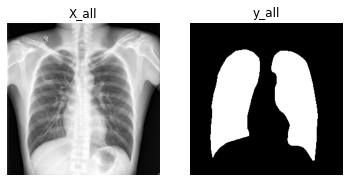

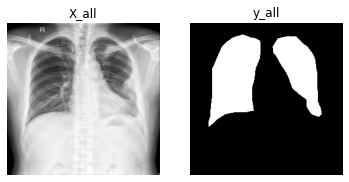

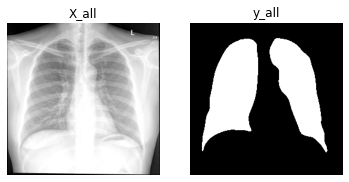

In [12]:
plotTrainData(X_all, y_all, 'all')

**학습, 검증, 테스트 데이터 셋으로 분리**

In [13]:
# fix random seed for reproductibility
seed = 5
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [14]:
# Check the shape of input
# image input for Keras (N:sample,H:Height,W:Width,C:Channel)
# image input for Pytorch (N:sample,C:Channel,H:Height,W:Width)

print('X_train',X_train.shape)
print('X_valid',X_valid.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_valid',y_valid.shape)
print('y_test',y_test.shape)

X_train (344, 256, 256, 3)
X_valid (87, 256, 256, 3)
X_test (108, 256, 256, 3)
y_train (344, 256, 256, 1)
y_valid (87, 256, 256, 1)
y_test (108, 256, 256, 1)


#STEP 2: Exploratory data analysis

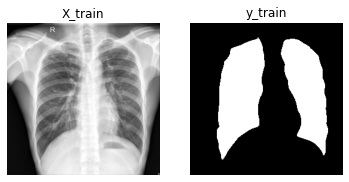

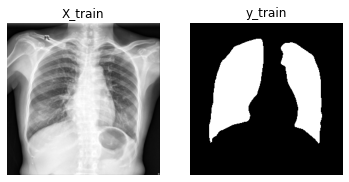

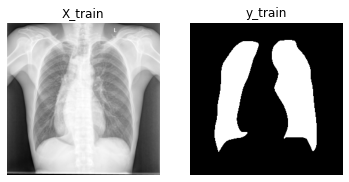

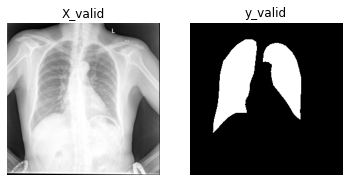

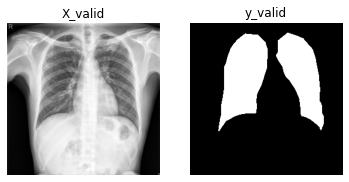

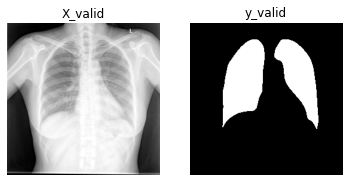

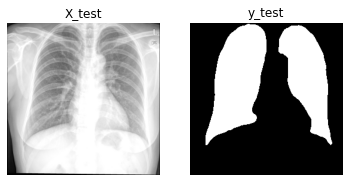

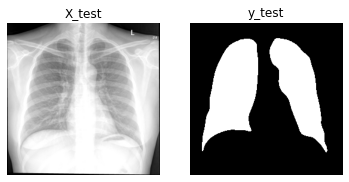

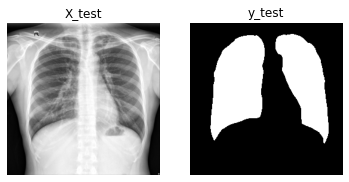

In [15]:
plotTrainData(X_train,y_train, 'train')
plotTrainData(X_valid,y_valid, 'valid')
plotTrainData(X_test,y_test, 'test')

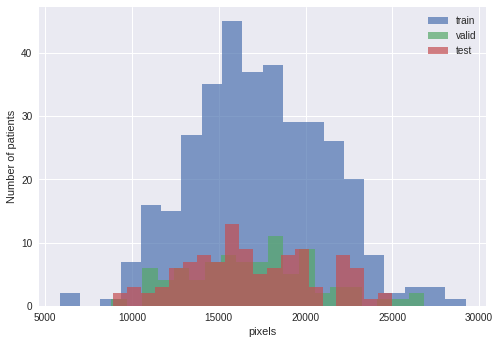

In [16]:
# 데이터셋별 pixel수 비교

y_pixel_train = []
y_pixel_valid = []
y_pixel_test = []

for idx in range(len(y_train)):
  y_pixel_train.append(np.count_nonzero(y_train[idx]))

for idx in range(len(y_valid)):
  y_pixel_valid.append(np.count_nonzero(y_valid[idx]))

for idx in range(len(y_test)):
  y_pixel_test.append(np.count_nonzero(y_test[idx]))

plt.style.use('seaborn')
plt.hist(y_pixel_train,bins=20,alpha=0.7,label='train')
plt.hist(y_pixel_valid,bins=20,alpha=0.7,label='valid')
plt.hist(y_pixel_test,bins=20,alpha=0.7,label='test')
plt.xlabel('pixels')
plt.ylabel('Number of patients')
plt.legend()

#STEP 3: VGG16 네트워크 다시보기

![대체 텍스트](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

In [17]:
import keras
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, UpSampling2D, Add, Conv2DTranspose, BatchNormalization
from keras.models import Model

def vgg16():
    inputs = Input(shape=(256, 256, 3,), name="VGGInput")
    
    conv1_1 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    bn1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(bn1_1)
    bn1_2 = BatchNormalization()(conv1_2)
    pool_1 = MaxPool2D(padding='same')(bn1_2)

    #(128,128)
    conv2_1 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(pool_1)
    bn2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(bn2_1)
    bn2_2 = BatchNormalization()(conv2_2)
    pool_2 = MaxPool2D(padding='same')(bn2_2)
    
    #(64, 64)
    conv3_1 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(pool_2)
    bn3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_1)
    bn3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_2)
    bn3_3 = BatchNormalization()(conv3_3)
    pool_3 = MaxPool2D(padding='same')(bn3_3)
    
    #(32, 32)
    conv4_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_3)
    bn4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_1)
    bn4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_2)
    bn4_3 = BatchNormalization()(conv4_3)
    pool_4 = MaxPool2D(padding='same')(bn4_3)
    
    #(16, 16)
    conv5_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_4)
    bn5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_1)
    bn5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_2)
    bn5_3 = BatchNormalization()(conv5_3)
    pool_5 = MaxPool2D(padding='same')(bn5_3)

    #(8, 8)
    x = Conv2D(filters=4096, kernel_size=(8,8), padding='valid', activation=relu)(pool_5)
    x = Flatten()(x)
    x = Dense(4096, activation=relu)(x)
    pred = Dense(1000, activation=softmax)(x)
        
    return Model(inputs=inputs, outputs=pred)

**FCN 32 - first fully convolutional network**

![image interpolation](https://matplotlib.org/_images/interpolation_methods.png)


**image interpolation**

#STEP 4: 첫번째 영상분할 모델 (FCN32s)

In [18]:
import keras
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, UpSampling2D, Add, Activation, Conv2DTranspose, BatchNormalization
from keras import optimizers
from keras.models import Model
from keras.optimizers import *

def fcn32s():
    inputs = Input(shape=(256, 256, 3,), name="FCNInput")
    
    conv1_1 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    bn1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(bn1_1)
    bn1_2 = BatchNormalization()(conv1_2)
    pool_1 = MaxPool2D(padding='same')(bn1_2)

    #(128,128)
    conv2_1 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(pool_1)
    bn2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(bn2_1)
    bn2_2 = BatchNormalization()(conv2_2)
    pool_2 = MaxPool2D(padding='same')(bn2_2)
    
    #(64, 64)
    conv3_1 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(pool_2)
    bn3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_1)
    bn3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_2)
    bn3_3 = BatchNormalization()(conv3_3)
    pool_3 = MaxPool2D(padding='same')(bn3_3)
    
    #(32, 32)
    conv4_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_3)
    bn4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_1)
    bn4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_2)
    bn4_3 = BatchNormalization()(conv4_3)
    pool_4 = MaxPool2D(padding='same')(bn4_3)
    
    #(16, 16)
    conv5_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_4)
    bn5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_1)
    bn5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_2)
    bn5_3 = BatchNormalization()(conv5_3)
    pool_5 = MaxPool2D(padding='same')(bn5_3)

    # VGG의 Fully Connected Layer 삭제
    #x = Conv2D(filters=4096, kernel_size=(8,8), padding='valid', activation=relu)(pool_5)
    #x = Flatten()(x)
    #x = Dense(4096, activation=relu)(x)
    #pred = Dense(1000, activation=softmax)(x)
        
    # 32배율 Upsample 추가
    conv_t1 = UpSampling2D(size = (32,32))(pool_5)    
    conv_t2 = Conv2D(1, (1,1), padding="valid", activation="relu")(conv_t1)
    
    pred = Activation('sigmoid')(conv_t2)
    
    return Model(inputs=inputs, outputs=pred)

In [19]:
import keras.backend as K

def dice_coef(y_true, y_pred):
    
    y_true_f = K.cast(y_true, dtype='float32')

    y_true_f = K.flatten(y_true_f)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

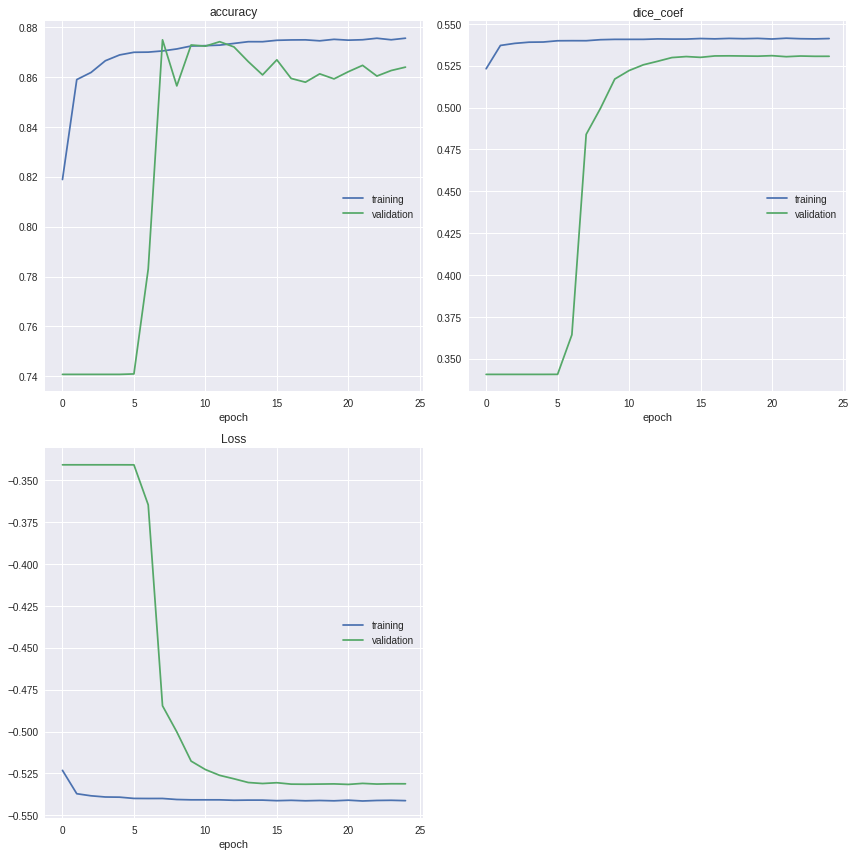

accuracy
	training         	 (min:    0.819, max:    0.875, cur:    0.875)
	validation       	 (min:    0.741, max:    0.875, cur:    0.864)
dice_coef
	training         	 (min:    0.523, max:    0.541, cur:    0.541)
	validation       	 (min:    0.341, max:    0.531, cur:    0.531)
Loss
	training         	 (min:   -0.541, max:   -0.523, cur:   -0.541)
	validation       	 (min:   -0.532, max:   -0.341, cur:   -0.531)
43/43 [==============================] - 12s 286ms/step - loss: -0.5412 - accuracy: 0.8755 - dice_coef: 0.5412 - val_loss: -0.5312 - val_accuracy: 0.8639 - val_dice_coef: 0.5306


In [20]:
# visualizer
from livelossplot import PlotLossesKeras
plotlosses = PlotLossesKeras()

# build the model
model = fcn32s()
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=dice_coef_loss, optimizer=sgd, metrics=['accuracy',dice_coef])
print(model.summary())

# fix random seed for reproductibility
seed = 7
np.random.seed(seed)

# FIT THE MODEL - OPTIMIZATION
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[plotlosses])
model.save('fcn-32s.h5')

#STEP 5: 결과 확인하기

In [21]:
import matplotlib.pyplot as plt

def plotPredictions(X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_, simpleFCN):
    model = simpleFCN     

    ix = np.random.randint(0, len(X_train_))
    input_ = X_train_[ix:ix+1]
    mask_ = y_train_[ix:ix+1]
    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], 'gray')
    plt.show()
    
    ix = np.random.randint(0, len(X_valid_))
    input_ = X_valid_[ix:ix+1]
    mask_ = y_valid_[ix:ix+1]
    preds_valid = model.predict(input_)
    preds_valid_t = (preds_valid > 0.5).astype(np.uint8)
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_valid")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_valid")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_valid_t[0][:,:,0], 'gray')
    plt.show()
    
    ix = np.random.randint(0, len(X_test_))
    input_ = X_test_[ix:ix+1]
    mask_ = y_test_[ix:ix+1]
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test_t[0][:,:,0], 'gray')
    plt.show()

1/1 [==============================] - 0s 2ms/step - loss: -0.6180 - accuracy: 0.8703 - dice_coef: 0.6180


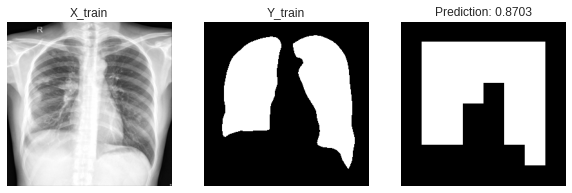

1/1 [==============================] - 0s 2ms/step - loss: -0.4883 - accuracy: 0.8990 - dice_coef: 0.4883


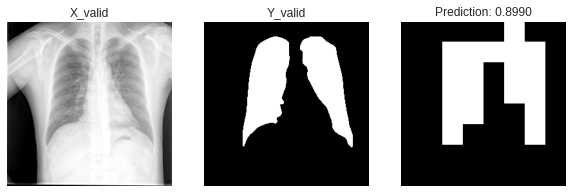

1/1 [==============================] - 0s 2ms/step - loss: -0.4917 - accuracy: 0.8932 - dice_coef: 0.4917


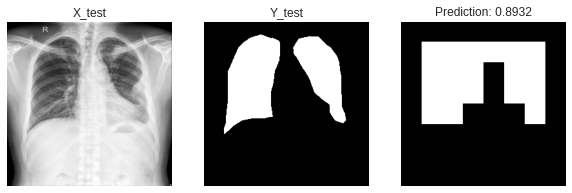

In [22]:
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

#STEP 6: 두번째 모델 (FCN8s)
**Skip Connection**

![대체 텍스트](http://deeplearning.net/tutorial/_images/fcn_schema.png)

In [23]:
import keras
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, UpSampling2D, Add, Conv2DTranspose, BatchNormalization
from keras.models import Model

def fcn8s():
    inputs = Input(shape=(256, 256, 3,), name="FCNInput")
    
    conv1_1 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    bn1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(bn1_1)
    bn1_2 = BatchNormalization()(conv1_2)
    pool_1 = MaxPool2D(padding='same')(bn1_2)

    #(128,128)
    conv2_1 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(pool_1)
    bn2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(bn2_1)
    bn2_2 = BatchNormalization()(conv2_2)
    pool_2 = MaxPool2D(padding='same')(bn2_2)
    
    #(64, 64)
    conv3_1 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(pool_2)
    bn3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_1)
    bn3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_2)
    bn3_3 = BatchNormalization()(conv3_3)
    pool_3 = MaxPool2D(padding='same')(bn3_3)
    
    #(32, 32)
    conv4_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_3)
    bn4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_1)
    bn4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_2)
    bn4_3 = BatchNormalization()(conv4_3)
    pool_4 = MaxPool2D(padding='same')(bn4_3)
    
    #(16, 16)
    conv5_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_4)
    bn5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_1)
    bn5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_2)
    bn5_3 = BatchNormalization()(conv5_3)
    pool_5 = MaxPool2D(padding='same')(bn5_3)

    #(8, 8)
    #x = Conv2D(filters=4096, kernel_size=(8,8), padding='valid', activation=relu)(pool_5)
    #x = Flatten()(x)
    #x = Dense(4096, activation=relu)(x)
    #pred = Dense(1000, activation=softmax)(x)
    
    #(8, 8)
    conv6 = Conv2D(2048, (1,1), padding="valid", activation="relu")(pool_5)
    conv7 = Conv2D(2048, (1,1), padding="valid", activation="relu")(conv6)
    conv8 = Conv2D(1, (1,1), padding="valid", activation="relu")(conv7)
    
    #(16, 16)
    score_pool4 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_4)
    conv_t1 = UpSampling2D(size = (2,2))(conv8)     
    fuse_1 = Add()([conv_t1,score_pool4])

    #(32, 32)
    score_pool3 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_3)
    conv_t2 = UpSampling2D(size = (2,2))(fuse_1)
    fuse_2 = Add()([conv_t2,score_pool3])
   
    conv_t3 = UpSampling2D(size = (8,8))(fuse_2)
    
    pred = Activation('sigmoid')(conv_t3)
    
    return Model(inputs=inputs, outputs=pred)


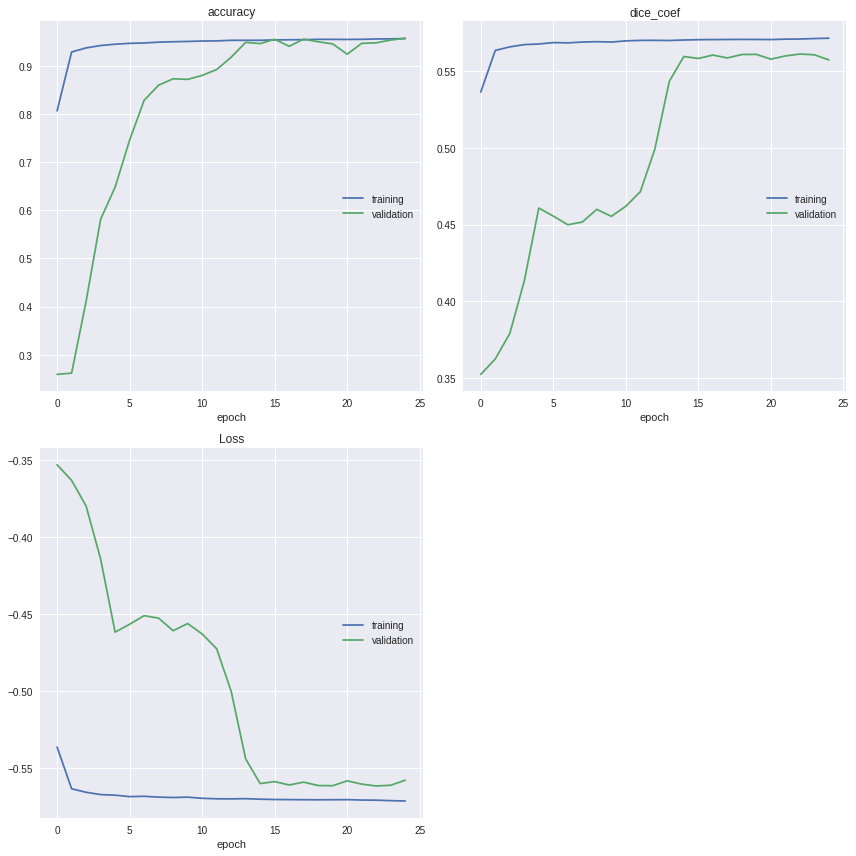

accuracy
	training         	 (min:    0.807, max:    0.957, cur:    0.957)
	validation       	 (min:    0.259, max:    0.957, cur:    0.957)
dice_coef
	training         	 (min:    0.536, max:    0.571, cur:    0.571)
	validation       	 (min:    0.352, max:    0.561, cur:    0.557)
Loss
	training         	 (min:   -0.571, max:   -0.536, cur:   -0.571)
	validation       	 (min:   -0.562, max:   -0.353, cur:   -0.558)
43/43 [==============================] - 10s 222ms/step - loss: -0.5714 - accuracy: 0.9566 - dice_coef: 0.5714 - val_loss: -0.5579 - val_accuracy: 0.9575 - val_dice_coef: 0.5573


In [24]:
# visualizer
from livelossplot import PlotLossesKeras
plotlosses = PlotLossesKeras()

# build the model
model = fcn8s()
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=dice_coef_loss, optimizer=sgd, metrics=['accuracy',dice_coef])
# fix random seed for reproductibility
seed = 7
np.random.seed(seed)

# FIT THE MODEL - OPTIMIZATION
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[plotlosses])
model.save('fcn-8s.h5')

1/1 [==============================] - 0s 2ms/step - loss: -0.6535 - accuracy: 0.9698 - dice_coef: 0.6535


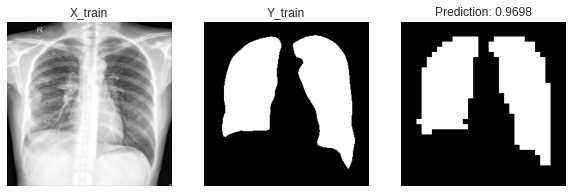

1/1 [==============================] - 0s 2ms/step - loss: -0.5047 - accuracy: 0.9694 - dice_coef: 0.5047


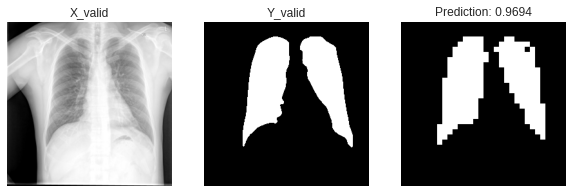

1/1 [==============================] - 0s 2ms/step - loss: -0.5129 - accuracy: 0.9597 - dice_coef: 0.5129


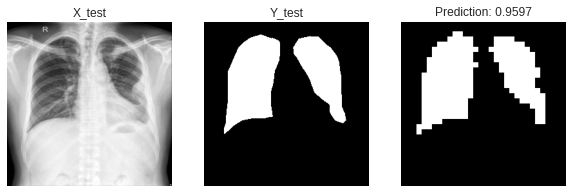

In [25]:
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

#STEP 6-1: 두번째 모델 (FCN8s)의 개선시도 -> (FCN2s)
**Skip Connection**

In [26]:
import keras
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, UpSampling2D, Add, Conv2DTranspose, Activation, BatchNormalization
from keras.models import Model
from keras.optimizers import *

def fcn2s():
    inputs = Input(shape=(256, 256, 3,), name="FCNInput")
    
    conv1_1 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    bn1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(bn1_1)
    bn1_2 = BatchNormalization()(conv1_2)
    pool_1 = MaxPool2D(padding='same')(bn1_2)

    #(128,128)
    conv2_1 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(pool_1)
    bn2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(bn2_1)
    bn2_2 = BatchNormalization()(conv2_2)
    pool_2 = MaxPool2D(padding='same')(bn2_2)
    
    #(64, 64)
    conv3_1 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(pool_2)
    bn3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_1)
    bn3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_2)
    bn3_3 = BatchNormalization()(conv3_3)
    pool_3 = MaxPool2D(padding='same')(bn3_3)
    
    #(32, 32)
    conv4_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_3)
    bn4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_1)
    bn4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_2)
    bn4_3 = BatchNormalization()(conv4_3)
    pool_4 = MaxPool2D(padding='same')(bn4_3)
    
    #(16, 16)
    conv5_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_4)
    bn5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_1)
    bn5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_2)
    bn5_3 = BatchNormalization()(conv5_3)
    pool_5 = MaxPool2D(padding='same')(bn5_3)

    #(8, 8)
    #x = Conv2D(filters=4096, kernel_size=(8,8), padding='valid', activation=relu)(pool_5)
    #x = Flatten()(x)
    #x = Dense(4096, activation=relu)(x)
    #pred = Dense(1000, activation=softmax)(x)
    
    #(8, 8)
    conv6 = Conv2D(2048, (1,1), padding="valid", activation="relu")(pool_5)
    conv7 = Conv2D(2048, (1,1), padding="valid", activation="relu")(conv6)
    conv8 = Conv2D(1, (1,1), padding="valid", activation="relu")(conv7)

    #(16, 16)
    score_pool4 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_4)
    conv_t1 = UpSampling2D(size = (2,2))(conv8)    
    fuse_1 = Add()([conv_t1,score_pool4])

    #(32, 32)
    score_pool3 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_3)
    conv_t2 = UpSampling2D(size = (2,2))(fuse_1)
    fuse_2 = Add()([conv_t2,score_pool3])
  
    #(64, 64)
    score_pool2 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_2)
    conv_t3 = UpSampling2D(size = (2,2))(fuse_2)
    fuse_3 = Add()([conv_t3,score_pool2])

    #(128, 128)
    score_pool1 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_1)
    conv_t4 = UpSampling2D(size = (2,2))(fuse_3)
    fuse_4 = Add()([conv_t4,score_pool1])
      
    conv_t5 = UpSampling2D(size = (2,2))(fuse_4)
    
    pred = Activation('sigmoid')(conv_t5)
    
    return Model(inputs=inputs, outputs=pred)

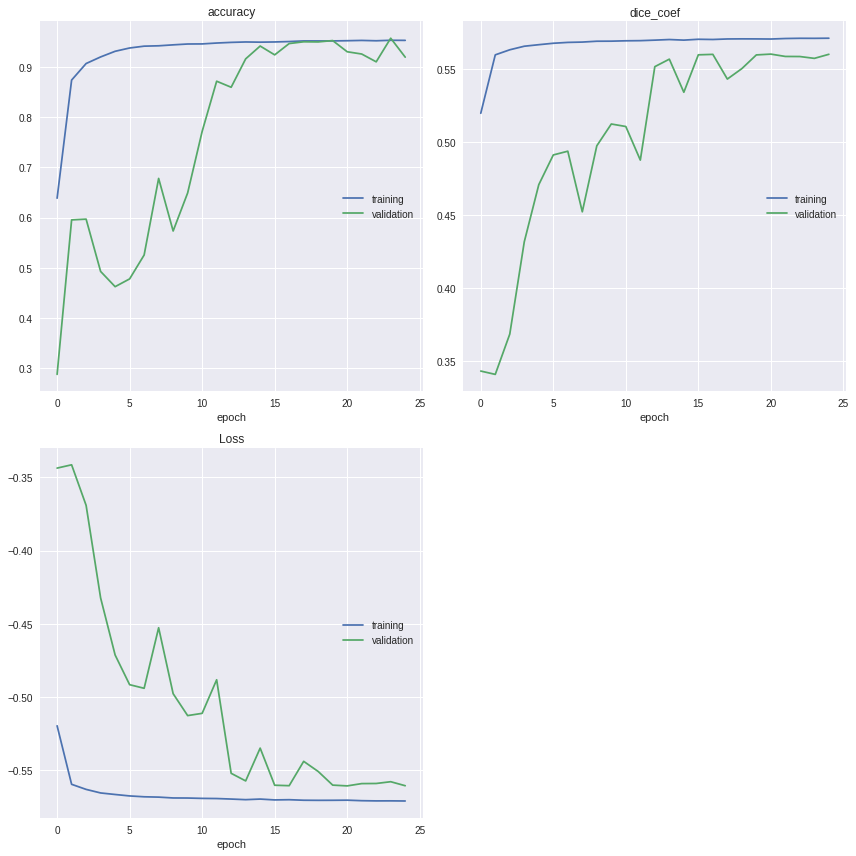

accuracy
	training         	 (min:    0.639, max:    0.953, cur:    0.953)
	validation       	 (min:    0.288, max:    0.957, cur:    0.919)
dice_coef
	training         	 (min:    0.520, max:    0.571, cur:    0.571)
	validation       	 (min:    0.341, max:    0.560, cur:    0.560)
Loss
	training         	 (min:   -0.571, max:   -0.520, cur:   -0.571)
	validation       	 (min:   -0.561, max:   -0.341, cur:   -0.561)
43/43 [==============================] - 10s 224ms/step - loss: -0.5712 - accuracy: 0.9526 - dice_coef: 0.5712 - val_loss: -0.5608 - val_accuracy: 0.9192 - val_dice_coef: 0.5602


In [27]:
# visualizer
from livelossplot import PlotLossesKeras
plotlosses = PlotLossesKeras()

# build the model
model = fcn2s()
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=dice_coef_loss, optimizer=sgd, metrics=['accuracy',dice_coef])

# fix random seed for reproductibility
seed = 7
np.random.seed(seed)

# FIT THE MODEL - OPTIMIZATION
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[plotlosses])
model.save('fcn-2s.h5')

1/1 [==============================] - 0s 1ms/step - loss: -0.6540 - accuracy: 0.9344 - dice_coef: 0.6540


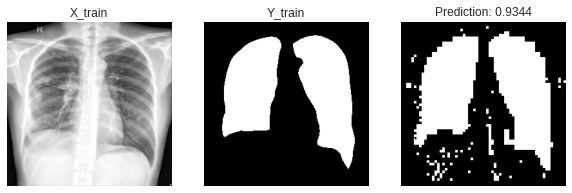

1/1 [==============================] - 0s 2ms/step - loss: -0.5115 - accuracy: 0.9316 - dice_coef: 0.5115


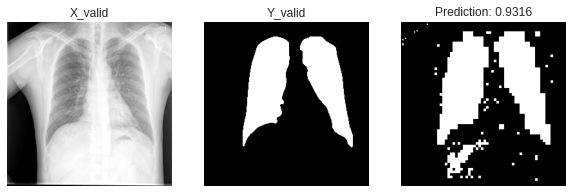

1/1 [==============================] - 0s 2ms/step - loss: -0.5145 - accuracy: 0.9226 - dice_coef: 0.5145


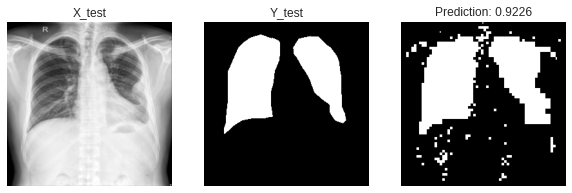

In [28]:
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

#STEP 7: 세번째 모델 (FCN8s with deconvolution)
**deconvolution**


![대체 텍스트](https://miro.medium.com/max/1086/1*AbCrAqPBfkqGRdhKtiZQqA.png)

In [29]:
import keras
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, UpSampling2D, Add, Conv2DTranspose, BatchNormalization, Activation
from keras.models import Model
from keras.optimizers import *

def fcn8s_deconv():
    inputs = Input(shape=(256, 256, 3,), name="FCNInput")
    
    conv1_1 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    bn1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(bn1_1)
    bn1_2 = BatchNormalization()(conv1_2)
    pool_1 = MaxPool2D(padding='same')(bn1_2)

    #(128,128)
    conv2_1 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(pool_1)
    bn2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(bn2_1)
    bn2_2 = BatchNormalization()(conv2_2)
    pool_2 = MaxPool2D(padding='same')(bn2_2)
    
    #(64, 64)
    conv3_1 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(pool_2)
    bn3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_1)
    bn3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(bn3_2)
    bn3_3 = BatchNormalization()(conv3_3)
    pool_3 = MaxPool2D(padding='same')(bn3_3)
    
    #(32, 32)
    conv4_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_3)
    bn4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_1)
    bn4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn4_2)
    bn4_3 = BatchNormalization()(conv4_3)
    pool_4 = MaxPool2D(padding='same')(bn4_3)
    
    #(16, 16)
    conv5_1 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(pool_4)
    bn5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_1)
    bn5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(bn5_2)
    bn5_3 = BatchNormalization()(conv5_3)
    pool_5 = MaxPool2D(padding='same')(bn5_3)

    #(8, 8)
    #x = Conv2D(filters=4096, kernel_size=(8,8), padding='valid', activation=relu)(pool_5)
    #x = Flatten()(x)
    #x = Dense(4096, activation=relu)(x)
    #pred = Dense(1000, activation=softmax)(x)
    
    #(8, 8)
    conv6 = Conv2D(2048, (1,1), padding="valid", activation="relu")(pool_5)
    conv7 = Conv2D(2048, (1,1), padding="valid", activation="relu")(conv6)
    conv8 = Conv2D(1, (1,1), padding="valid", activation="relu")(conv7)
 
    #(16, 16)
    score_pool4 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_4)
    
    conv_t1 = Conv2DTranspose(1, kernel_size=(2,2), strides=(2,2), padding="same")(conv8)
    conv_t1 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv_t1)
    conv_t1 = BatchNormalization()(conv_t1)
    conv_t1 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv_t1)
    conv_t1 = BatchNormalization()(conv_t1)
    
    fuse_1 = Add()([conv_t1,score_pool4])

    #(32, 32)
    score_pool3 = Conv2D(1, (1,1), padding="valid", activation="relu")(pool_3)
    
    conv_t2 = Conv2DTranspose(1, kernel_size=(2,2), strides=(2,2),padding="same")(fuse_1)
    conv_t2 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv_t2)
    conv_t2 = BatchNormalization()(conv_t2)
    conv_t2 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv_t2)
    conv_t2 = BatchNormalization()(conv_t2)
    
    fuse_2 = Add()([conv_t2,score_pool3])

    #(32, 32) x 8 = 256
    conv_t3 = Conv2DTranspose(1, kernel_size=(8,8), strides=(8,8), padding="same")(fuse_2)
    conv_t3 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv_t3)
    conv_t3 = BatchNormalization()(conv_t3)
    conv_t3 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv_t3)
    conv_t3 = BatchNormalization()(conv_t3)
    
    pred = Activation('sigmoid')(conv_t3)
    
    return Model(inputs=inputs, outputs=pred)

In [30]:
#model = fcn8s_deconv()
#model.summary()

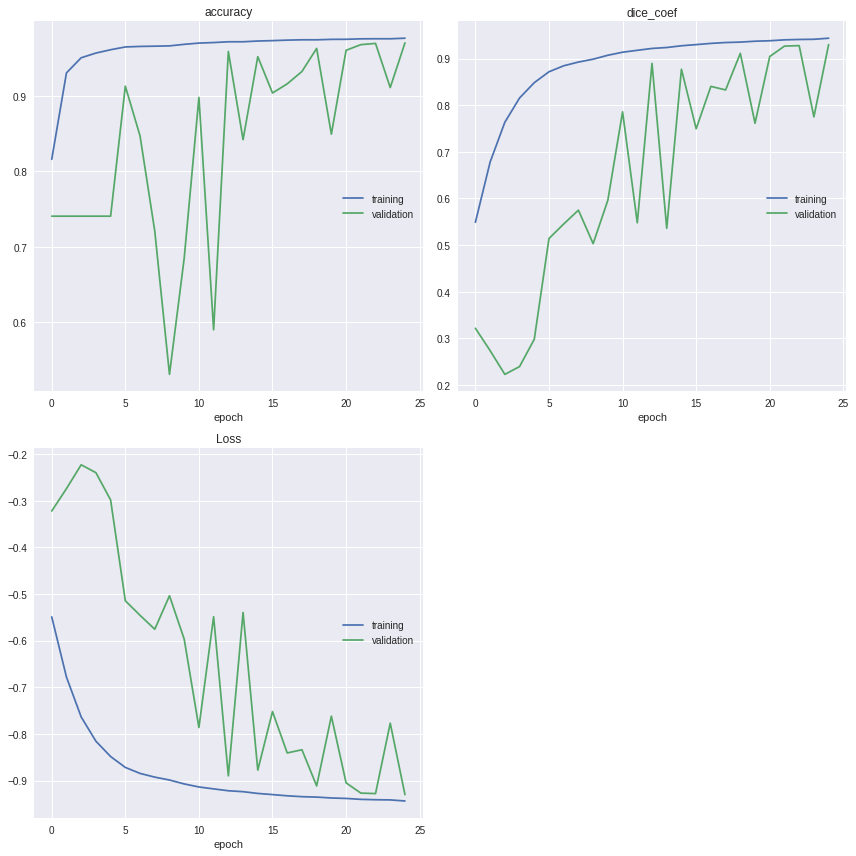

accuracy
	training         	 (min:    0.816, max:    0.976, cur:    0.976)
	validation       	 (min:    0.531, max:    0.970, cur:    0.970)
dice_coef
	training         	 (min:    0.549, max:    0.944, cur:    0.944)
	validation       	 (min:    0.223, max:    0.930, cur:    0.930)
Loss
	training         	 (min:   -0.944, max:   -0.549, cur:   -0.944)
	validation       	 (min:   -0.930, max:   -0.223, cur:   -0.930)
43/43 [==============================] - 10s 227ms/step - loss: -0.9438 - accuracy: 0.9765 - dice_coef: 0.9438 - val_loss: -0.9302 - val_accuracy: 0.9703 - val_dice_coef: 0.9301


In [31]:
# visualizer
from livelossplot import PlotLossesKeras
plotlosses = PlotLossesKeras()

# build the model
model = fcn8s_deconv()
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=dice_coef_loss, optimizer=sgd, metrics=['accuracy',dice_coef])

# fix random seed for reproductibility
seed = 7
np.random.seed(seed)

# FIT THE MODEL - OPTIMIZATION
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[plotlosses])
model.save('fcn-8s_deconv.h5')

1/1 [==============================] - 0s 2ms/step - loss: -0.9554 - accuracy: 0.9767 - dice_coef: 0.9554


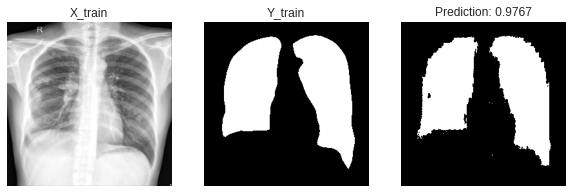

1/1 [==============================] - 0s 2ms/step - loss: -0.9417 - accuracy: 0.9813 - dice_coef: 0.9417


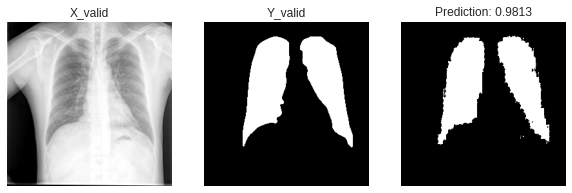

1/1 [==============================] - 0s 2ms/step - loss: -0.9265 - accuracy: 0.9728 - dice_coef: 0.9265


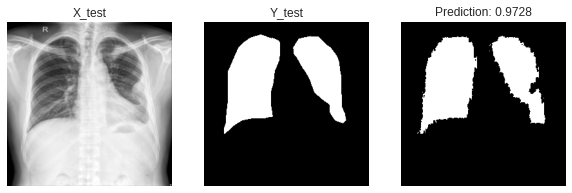

In [32]:
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

#STEP 8: 마지막 모델 (Unet)
**concatenation**


![대체 텍스트](https://www.renom.jp/notebooks/tutorial/image_processing/u-net/unet.png)

![대체 텍스트](http://2rct3i2488gxf9jvb1lqhek9-wpengine.netdna-ssl.com/wp-content/uploads/2017/05/fcn.png)

In [33]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [34]:
#model = unet()
#model.summary()

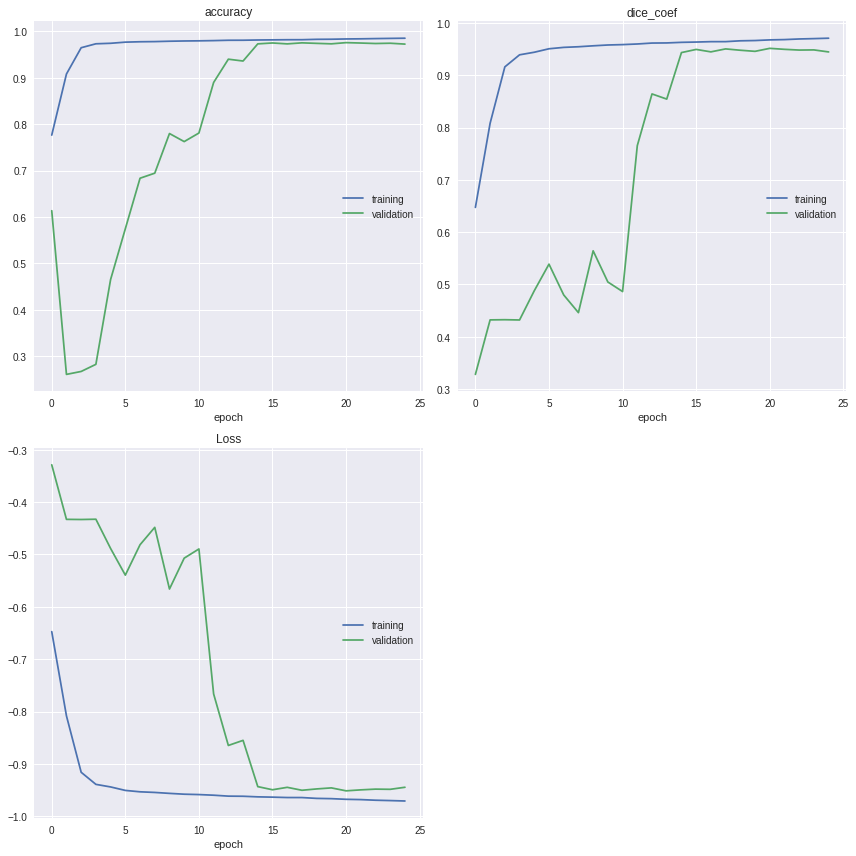

accuracy
	training         	 (min:    0.776, max:    0.985, cur:    0.985)
	validation       	 (min:    0.261, max:    0.976, cur:    0.973)
dice_coef
	training         	 (min:    0.647, max:    0.971, cur:    0.971)
	validation       	 (min:    0.328, max:    0.951, cur:    0.945)
Loss
	training         	 (min:   -0.971, max:   -0.647, cur:   -0.971)
	validation       	 (min:   -0.951, max:   -0.329, cur:   -0.945)
43/43 [==============================] - 8s 195ms/step - loss: -0.9708 - accuracy: 0.9853 - dice_coef: 0.9708 - val_loss: -0.9445 - val_accuracy: 0.9726 - val_dice_coef: 0.9445


In [35]:
# visualizer
from livelossplot import PlotLossesKeras
plotlosses = PlotLossesKeras()

# build the model
model = unet()
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=dice_coef_loss, optimizer=sgd, metrics=['accuracy',dice_coef])

# fix random seed for reproductibility
seed = 7
np.random.seed(seed)

# FIT THE MODEL - OPTIMIZATION
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[plotlosses])
model.save('unet.h5')

1/1 [==============================] - 0s 2ms/step - loss: -0.9684 - accuracy: 0.9794 - dice_coef: 0.9684


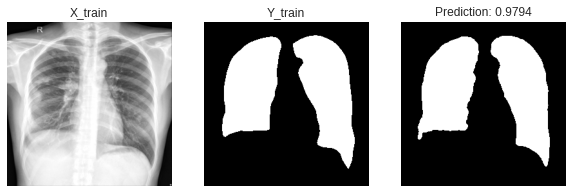

1/1 [==============================] - 0s 2ms/step - loss: -0.9561 - accuracy: 0.9822 - dice_coef: 0.9561


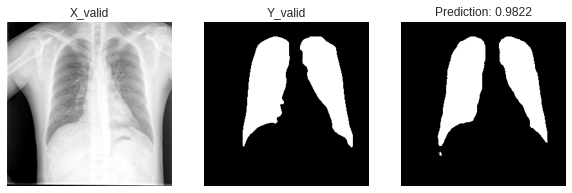

1/1 [==============================] - 0s 2ms/step - loss: -0.9517 - accuracy: 0.9791 - dice_coef: 0.9517


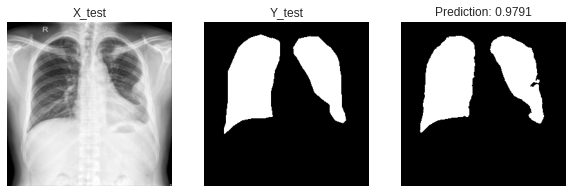

In [36]:
plotPredictions(X_train, y_train, X_valid, y_valid, X_test, y_test, model)

# Take Home Message

* NN-UNET(Official) : https://github.com/MIC-DKFZ/nnUNet
* NN-UNET(easy) : https://github.com/kevinkwshin/easy-nnUNet
